In [1]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

Plots.GRBackend()

## Generate the (noisy) training dataset

In [209]:
function LV(du, u, p, t)
    A, B, C, D = p
    du[1] = A*u[1] - B*u[1]*u[2]
    du[2] = C*u[2] - D*u[1]*u[2]
end


p_ = Float32[1.3, 0.9, 0.8, 1.8]


# Define the experimental parameter

tspan = (0.0f0, 4.0f0)
u0 = Float32[0.8, 3]
p_ = Float32[1.3, 0.9, -1.8, -0.8]

prob = ODEProblem(LV, u0, tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.1)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training dataset

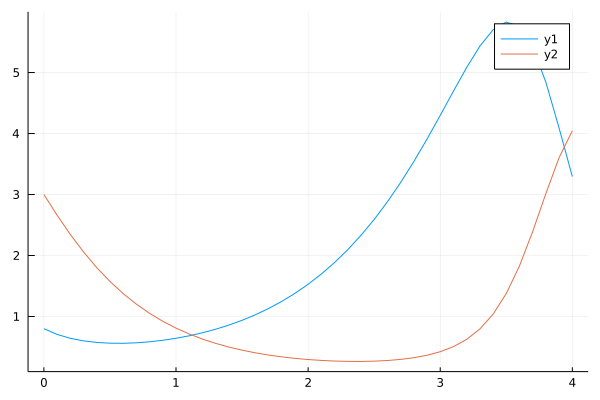

In [210]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(solution.t, Xₙ[1, :])
plot!(solution.t, Xₙ[2, :])

## UADE

In [211]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x - p_[2]*z[1],
    p_[3]*y  - p_[4]*z[2]]
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = 0.1);

## Plot the untrained solution

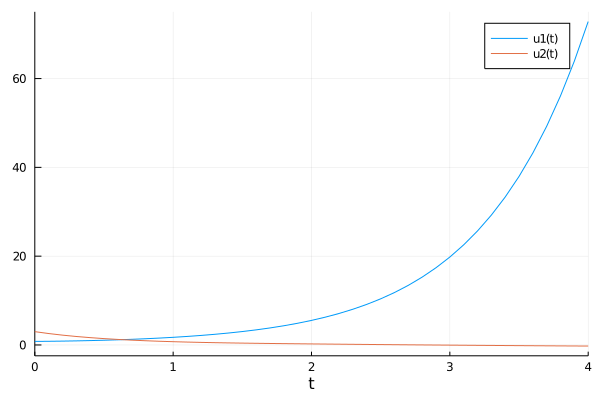

In [212]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [213]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = 0.1,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [214]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 200)

loss: 512:   5%|███                                     |  ETA: 0:01:32

Current loss after 10 iterations: 512.4792


loss: 456:  10%|█████                                   |  ETA: 0:01:20

Current loss after 20 iterations: 455.99716


loss: 442:  15%|███████                                 |  ETA: 0:01:10

Current loss after 30 iterations: 442.48874


loss: 434:  20%|█████████                               |  ETA: 0:01:02

Current loss after 40 iterations: 434.0754


loss: 427:  25%|███████████                             |  ETA: 0:00:56

Current loss after 50 iterations: 426.82297


loss: 420:  30%|█████████████                           |  ETA: 0:00:51

Current loss after 60 iterations: 419.71606


loss: 412:  35%|███████████████                         |  ETA: 0:00:47

Current loss after 70 iterations: 412.42288


loss: 405:  40%|█████████████████                       |  ETA: 0:00:43

Current loss after 80 iterations: 404.822


loss: 397:  45%|███████████████████                     |  ETA: 0:00:39

Current loss after 90 iterations: 396.85486


loss: 388:  50%|█████████████████████                   |  ETA: 0:00:36

Current loss after 100 iterations: 388.47064


Current loss after 110 iterations: 379.60196


loss: 370:  60%|█████████████████████████               |  ETA: 0:00:28

Current loss after 120 iterations: 370.1511


loss: 360:  65%|███████████████████████████             |  ETA: 0:00:24

Current loss after 130 iterations: 359.97327


loss: 349:  70%|█████████████████████████████           |  ETA: 0:00:21

Current loss after 140 iterations: 348.85233


loss: 336:  75%|███████████████████████████████         |  ETA: 0:00:18

Current loss after 150 iterations: 336.45447


loss: 322:  80%|█████████████████████████████████       |  ETA: 0:00:14

Current loss after 160 iterations: 322.2387


loss: 305:  85%|███████████████████████████████████     |  ETA: 0:00:11

Current loss after 170 iterations: 305.26108


loss: 284:  90%|█████████████████████████████████████   |  ETA: 0:00:07

Current loss after 180 iterations: 283.69818


loss: 254:  95%|███████████████████████████████████████ |  ETA: 0:00:04

Current loss after 190 iterations: 253.52562


loss: 205: 100%|████████████████████████████████████████| Time: 0:01:11


Current loss after 200 iterations: 204.61125


 * Status: success

 * Candidate solution
    Final objective value:     2.046113e+02

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   79  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


## Training with BFGS

In [218]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

Current loss after 620 iterations: 48.53391
Current loss after 630 iterations: 32.885197
Current loss after 640 iterations: 19.860334
Current loss after 650 iterations: 14.15158
Current loss after 660 iterations: 8.384891
Current loss after 670 iterations: 5.442238
Current loss after 680 iterations: 3.024619
Current loss after 690 iterations: 1.7521223
Current loss after 700 iterations: 1.2477045
Current loss after 710 iterations: 0.73842573
Current loss after 720 iterations: 0.29585302
Current loss after 730 iterations: 0.2580756
Current loss after 740 iterations: 0.16636053


 * Status: success

 * Candidate solution
    Final objective value:     1.663605e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.46e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.98e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.93e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   428  (vs limit Inf)
    Iterations:    130
    f(x) calls:    457
    ∇f(x) calls:   457


## Plot the loss

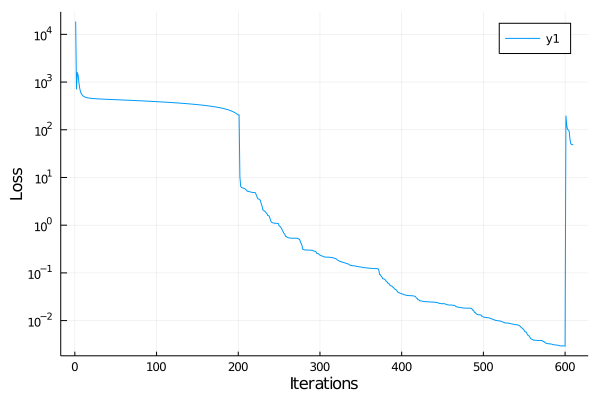

In [217]:
plot(losses, yaxis=:log, xlabel = "Iterations", ylabel = "Loss")

## Prediction

In [201]:
function dudt2_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x - p_[2]*z[1],
    p_[3]*y  - p_[4]*z[2]]
end

# ODE problem
tspan2 = (0.0f0, 10.0f0)
prob_nn2 = ODEProblem(dudt2_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.1);

## Plot the approximator prediction

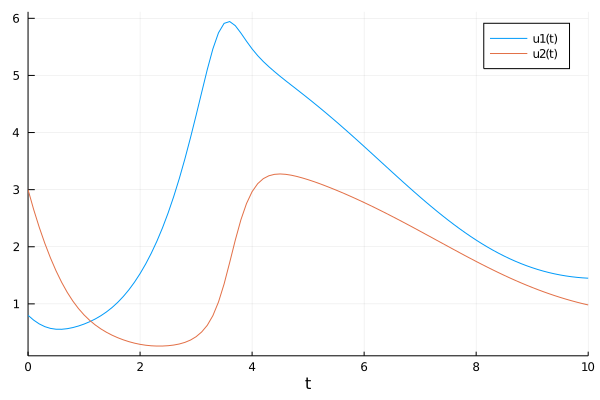

In [202]:
plot(sol_nn2)
#scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :])

## Plot the approximation and the original data

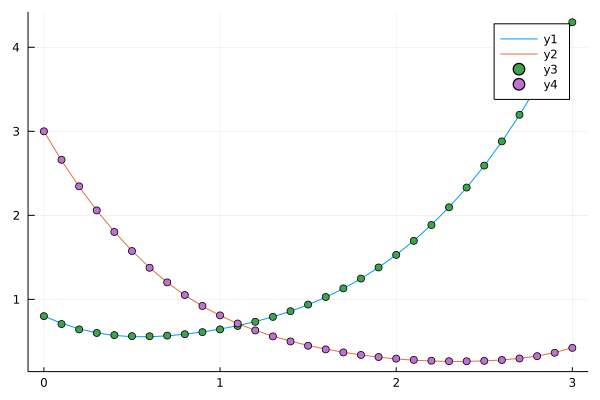

In [203]:
# Plot the data and the approximation
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution')
scatter!(solution.t, X')

## Test the prediction

In [204]:
tspan_test = (0.0f0, 10.0f0)
prob_test = ODEProblem(LV, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), saveat = 0.1);

## Plot Toghether True And Prediction
### Phase Space Plot

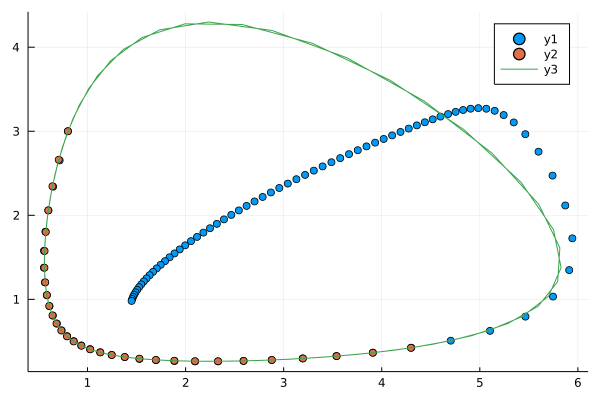

In [205]:
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :])
scatter!(Array(solution)[1, :], Array(solution)[2, :])
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :])

## Plot $x(t)$ and $y(t)$

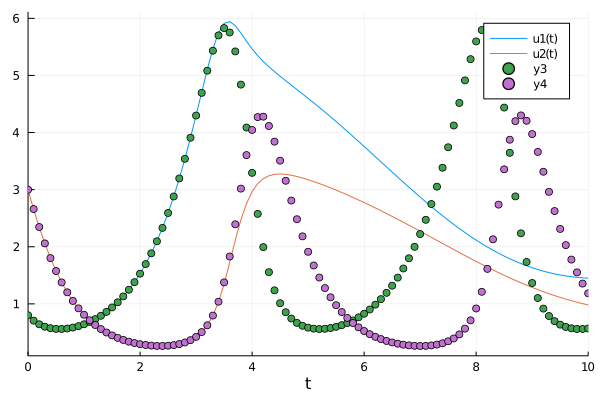

In [206]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :])
scatter!(solution_test.t, Array(solution_test)[2, :])